# Set-up

In [1]:
import sys
import torch

print(f"Python executable: {sys.executable}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
CUDA available: False


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3.profiler import profile
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

sam3_root = os.path.join(os.path.dirname(sam3.__file__))

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
if device == "cpu":
    print("Running on CPU. For better performance, please run on a GPU.")
    torch.backends.cpu.get_cpu_capability()
else:
    # turn on tfloat32 for Ampere GPUs
    # https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

Running on CPU. For better performance, please run on a GPU.


# Build Model

In [5]:
@profile()
def build_model(bpe_path, device):
    # bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
    print(f"Loading model on device: {device}")
    model = build_sam3_image_model(bpe_path=bpe_path, device=device)
    return model

In [6]:
@profile()
def inference(model, image):
    # image_path = f"{sam3_root}/../assets/images/test_image.png"
    # image = Image.open(image_path)
    # width, height = image.size
    processor = Sam3Processor(model, confidence_threshold=0.5)
    inference_state = processor.set_image(image)
    return processor, inference_state

# Text Prompt

In [ ]:
# processor.model.backbone

SAM3VLBackbone(
  (vision_backbone): Sam3DualViTDetNeck(
    (trunk): ViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      )
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (ls1): Identity()
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4736, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=4736, out_features=1024, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
      

In [7]:
@profile()
def prompt_and_predict(processor, inference_state, prompt="people"):
    processor.reset_all_prompts(inference_state)
    inference_state = processor.set_text_prompt(state=inference_state, prompt=prompt)
    return inference_state

## Load Model

In [ ]:
model = build_model(bpe_path=f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz", device=device)

In [47]:
image_path = f"{sam3_root}/../assets/images/truck.jpg"
image = Image.open(image_path)
processor, inference_state = inference(model, image)

[PROFILED] inference | Time: 5.395798s | Memory Used: 0.000000 MB


[PROFILED] prompt_and_predict | Time: 0.635214s | Memory Used: 0.000000 MB
found 1 object(s)


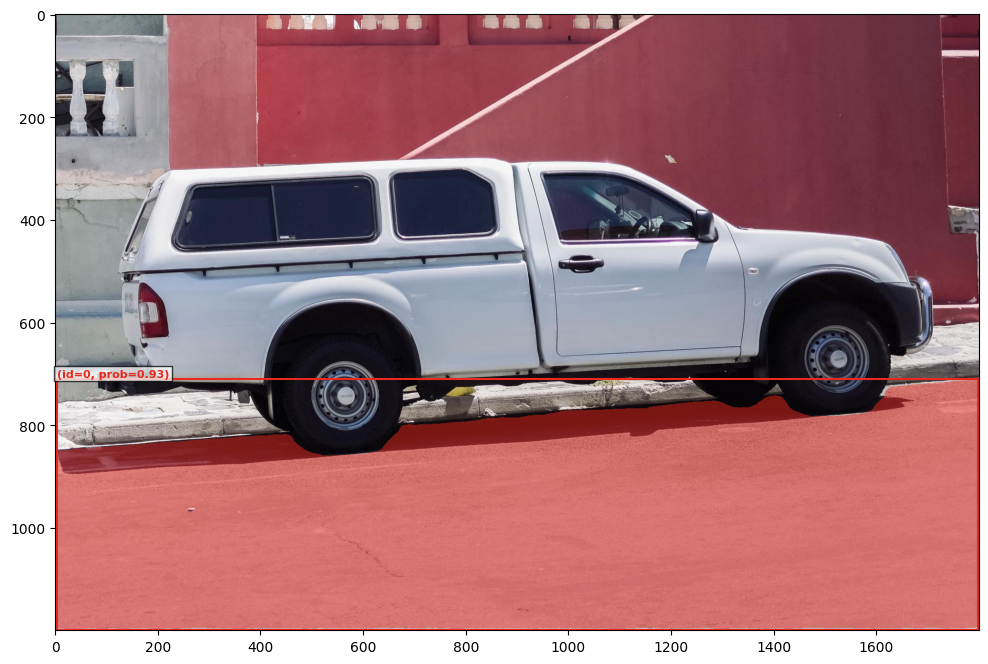

In [53]:
prompt = ["foot","people","road","wall","railing","truck","drain","light","car","seat","bag","food","hair-band","pant","hair","door","window","kids"]
inference_state = prompt_and_predict(processor, inference_state, prompt=prompt[0])

img0 = Image.open(image_path)
plot_results(img0, inference_state)

In [54]:
image_folder = f"{sam3_root}/../assets/images/"
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]

for image_file in image_files: 
    print(f"Processing image: {image_file}")
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    processor, inference_state = inference(model, image)
    # inference_state = prompt_and_predict(processor, inference_state, prompt=prompt)

    # prompts = ["people", "kids", "chair", "foot", "floor", "wall", "ceiling", "table", "window", "truck", "van", "door", "shoe", "food", "bag", "box", "bottle", "cup", "plate", "food", "book", "laptop", "phone"]
    prompts = ["foot","people","road","floor","wall","ceiling", "table","railing","truck","drain","light","car","seat","bag","food","hair-band","pant","hair","door","window","kids"]
    for prompt in prompts:
        inference_state = prompt_and_predict(processor, inference_state, prompt=prompt)
    # plot_results(img0, inference_state)

Processing image: groceries.jpg
[PROFILED] inference | Time: 5.339337s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.649253s | Memory Used: 0.004096 MB
[PROFILED] prompt_and_predict | Time: 0.609729s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.603223s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.629446s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.632032s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.606947s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.595018s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.608981s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.604478s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.609029s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.602517s | Memory Used: 0.000000 MB
[PROFILED] prompt_and_predict | Time: 0.609618s | Memory Used: 0.000000 MB
[P

# Visual Prompt: A Single Bounding Box

Normalized box input: [0.2096395045518875, 0.32103824615478516, 0.043103449046611786, 0.24590164422988892]


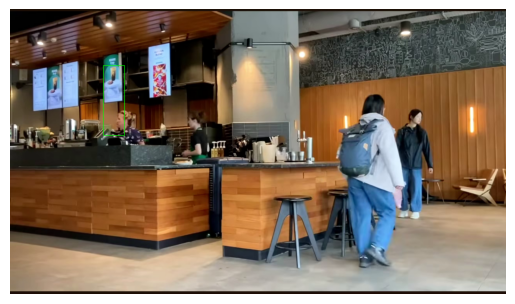

In [ ]:
# Here the box is in  (x,y,w,h) format, where (x,y) is the top left corner.
width, height = image.size
box_input_xywh = torch.tensor([480.0, 290.0, 110.0, 360.0]).view(-1, 4)
box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
print("Normalized box input:", norm_box_cxcywh)

processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(
    state=inference_state, box=norm_box_cxcywh, label=True
)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

# Clean-up

In [55]:
# Free Torch memory from CPU and GPU
if device == "cuda":
    torch.cuda.empty_cache()
elif device == "cpu": # Free memory on CPU - Works only on Linux
    import ctypes
    import gc

    # Delete Processor and Model to free up memory if they are still in scope
    if 'inference_state' in locals():
        del inference_state
    if 'processor' in locals():
        del processor
    if 'model' in locals():
        del model
    
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)

    gc.collect()